In [29]:
import os
import sys
from tqdm import tqdm 
import pandas as pd
# from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch, helpers
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings


In [16]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# Add the app directory to the Python path
app_dir = os.path.join(notebook_dir, '../app')
sys.path.append(app_dir)
from src.constants import model_name,index_name, embedding_size, HF_API_TOKEN

### Evaluate RAG

#### read dataset

In [5]:
# Read data into dataframe 
data_file_path = os.path.join('..','app','data', 'chunked_data.csv')
df = pd.read_csv(data_file_path).dropna() 

# Convert dataframe to list of dictionaries
data_dict = df.to_dict(orient="records")

In [6]:
data_dict[100]

{'id': 100,
 'title': 'Why we love, why we cheat',
 'speaker': 'Helen Fisher',
 'topics': "['culture', 'science']",
 'transcript': " I'm just simply saying that a world without love is a deadly place So now — (Applause) Thank you I want to end with a story And then, just a comment I've been studying romantic love and sex and attachment for 30 years I'm an identical twin; I am interested in why we're all alike Why you and I are alike, why the Iraqis and the Japanese and the Australian Aborigines and the people of the Amazon River are all alike"}

In [7]:
doc_idx = {d['id']: d for d in data_dict}

#### Get ground truth data

In [8]:
ground_truth_file_path = os.path.join('ground_truth.csv')
df_ground_truth = pd.read_csv(ground_truth_file_path, header = 0, usecols=[0, 1])

In [9]:
ground_truth = df_ground_truth.to_dict(orient='records')

In [10]:
print(len(ground_truth), ground_truth[0])

258 {'question': 'What topic does Hans Rosling primarily address in his talk?', 'id': 0}


#### create vector embeddings 

In [59]:
emb_model = HuggingFaceInferenceAPIEmbeddings(
        api_key=HF_API_TOKEN, 
        model_name="sentence-transformers/all-MiniLM-l6-v2"
    )
index_name = 'ted-eval'
es = Elasticsearch("http://localhost:9200")

In [60]:
index_settings={
    "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
        "title": {"type": "text"},
        "transcript": {"type": "text"}, 
        "topics": {"type": "text"}, 
        "speaker": {"type": "text"}, 
        "about_speakers": {"type": "text"}, 
        "description": {"type": "text"}, 
        "title_transcript_vector": {"type": "dense_vector", "dims": embedding_size, "index": True, "similarity": "cosine"},
        }
    }
}

# Create Index and delete if it already exists
es.indices.delete(index=index_name, ignore_unavailable=True)
es.indices.create(index=index_name, body = index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ted-eval'})

Embedding the answer and query vector

In [61]:
batch_size = 100
def get_embeddings_batch( texts):
    """
    Generates embedding vectors for a batch of texts using the Hugging Face endpoint.
    """
    data = emb_model.embed_documents(texts)[:embedding_size]
    return data 

In [62]:
vector_data_dict = []
for i in tqdm(range(0, len(data_dict), batch_size)):
    batch = data_dict[i:i + batch_size]
    title_transcripts = [f"{data['title']} {data['transcript']}" for data in batch]
    transcripts = [data['transcript'] for data in batch]
    transcript_embeddings = get_embeddings_batch(transcripts)
    title_transcript_embeddings = get_embeddings_batch(title_transcripts)
    
    for j, data in enumerate(batch):
        data['transcript_vector'] = transcript_embeddings[j][:embedding_size]
        data['title_transcript_vector'] = title_transcript_embeddings[j][:embedding_size]
        vector_data_dict.append(data)

100%|██████████| 23/23 [01:25<00:00,  3.73s/it]


In [64]:
vector_data_dict[0].keys()

dict_keys(['id', 'title', 'speaker', 'topics', 'transcript', 'transcript_vector', 'title_transcript_vector'])

#### Creating index on data

In [65]:

# Add Data to Index using index() 
actions = [
    {
        "_index": index_name,
        "_id": i,
        "_source": row
    }
    for i, row in enumerate(vector_data_dict)
]
helpers.bulk(es, actions)

(2290, [])

In [66]:
print(es.info())

{'name': '58ce424d0117', 'cluster_name': 'docker-cluster', 'cluster_uuid': '0F660e46RlOZvAeyTjObFw', 'version': {'number': '8.7.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '09520b59b6bc1057340b55750186466ea715e30e', 'build_date': '2023-03-27T16:31:09.816451435Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [67]:
def elastic_search_knn(field, vector):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 3,
        "num_candidates": 100,
    }
    search_query = {
        "knn": knn,
        "_source": ["transcript", "title", "topic", "id"]
    }
    es_results = es.search(
        index=index_name, 
        body=search_query
    )
    result_docs = []
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

#### RAG Flow

In [68]:
from langchain_huggingface import HuggingFaceEndpoint

In [75]:
def title_transcript_vector_knn(q):
    question = q['question'] 
    v_q = emb_model.embed_query(question)[:embedding_size]

    return elastic_search_knn('title_transcript_vector', v_q)

In [76]:
def generate_prompt(query, context):
    prompt_template = """
    You are a TED Talks Q&A Assistant. 
    Answer the question about the talks using the speaker's transcript of the talk below, summarizing what the speaker meant to say.
    QUESTION: {question}
    CONTEXT: 
    {context}
    Provide a clear and insightful answer.
    """.strip()

    prompt = prompt_template.format(question=query, context=context)
    return prompt

In [77]:
def llm(prompt):
    repo_id = "mistralai/Mistral-7B-Instruct-v0.2"

    llm = HuggingFaceEndpoint(
        repo_id=repo_id,
        max_length=128,
        temperature=0.5,
        huggingfacehub_api_token=HF_API_TOKEN,
    ) 
    llm_response = llm.invoke(prompt) 
    return llm_response 

In [78]:
def rag_pipeline(query: dict) -> str:
    search_results =title_transcript_vector_knn(query)
    prompt = generate_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [79]:
ground_truth[100]

{'question': 'How does experience simulation benefit human decision-making?',
 'id': 140}

In [85]:
rag_pipeline(ground_truth[100])

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\h4has\.cache\huggingface\token
Login successful


'\n\nAnswer:\nThe speaker in the TED Talks suggests that the human brain, specifically the prefrontal cortex, has evolved to become an experience simulator. This ability to simulate experiences is crucial for decision-making. Intrinsic motivation, such as autonomy, mastery, and purpose, is more effective in enhancing decision-making and creativity than extrinsic motivators, like carrots and sticks. However, the speaker also points out that the use of extrinsic motivators can sometimes dull thinking and block creativity, as seen in various studies. Therefore, understanding the role of experience simulation in decision-making and the impact of intrinsic and extrinsic motivators can lead to more effective and productive outcomes.'

In [84]:
doc_idx[140]['transcript']

" Human beings have this marvelous adaptation that they can actually have experiences in their heads before they try them out in real life This is a trick that none of our ancestors could do, and that no other animal can do quite like we can It's a marvelous adaptation It's up there with opposable thumbs and standing upright and language as one of the things that got our species out of the trees and into the shopping mall"

In [87]:
answer_llm = '\n\nAnswer:\nThe speaker in the TED Talks suggests that the human brain, specifically the prefrontal cortex, has evolved to become an experience simulator. This ability to simulate experiences is crucial for decision-making. Intrinsic motivation, such as autonomy, mastery, and purpose, is more effective in enhancing decision-making and creativity than extrinsic motivators, like carrots and sticks. However, the speaker also points out that the use of extrinsic motivators can sometimes dull thinking and block creativity, as seen in various studies. Therefore, understanding the role of experience simulation in decision-making and the impact of intrinsic and extrinsic motivators can lead to more effective and productive outcomes.'
answer_orig = doc_idx[140]['transcript']

In [90]:
import numpy as np
v_llm = np.array(emb_model.embed_query(answer_llm))
v_orig = np.array(emb_model.embed_query(answer_orig))
result = np.dot(v_llm, v_orig)
print(result)


0.3364782018812696


In [91]:
answers ={}

#### Generate LLM answers 

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag_pipeline(rec)
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['transcript'] 
    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'id': doc_id,
        'question': rec['question']
    }

In [144]:
answers[30]

{'answer_llm': '\n\nAnswer:\nThe speaker, who gave the talks "Why we love, why we cheat" and "The secret to desire in a long-term relationship," explains that the sex drive is designed to motivate us to seek out potential partners. However, romantic love evolved to help us focus our mating energy on one individual at a time, thereby conserving our mating time and energy. The intense craving and obsession that come with romantic love help us to invest our emotional and mental resources in one person, making the relationship more meaningful and efficient. Additionally, desire in a long-term relationship requires space and needs to be nurtured, and romantic love provides the foundation for that desire to flourish.',
 'answer_orig': " And I think that the sex drive evolved to get you out there, looking for a whole range of partners You can feel it when you're just driving along in your car It can be focused on nobody I think romantic love evolved to enable you to focus your mating energy o

In [155]:
# Save data to file
answers_df = pd.DataFrame.from_dict(answers)
answers_df.to_csv('rag_eval.csv', index=False)

In [146]:
answers_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
answer_llm,\n I. Hans Rosling does not primarily addre...,"\n\nAnswer:\nHans Rosling, in his TED Talk ""Th...",\n\nAnswer:\nThe speaker did not provide speci...,\n\nAnswer:\nThe main issue with the students'...,\n ANSWER: Hans Rosling did not create a sp...,\n ANSWER:\n Hans Rosling differentiates...,\n ANSWER:\n Hans Rosling observed signi...,"\n\nAnswer:\nHans Rosling, in his talk ""The be...","\n\nAnswer:\nIn the 1980s, Bangladesh underwen...","\n\nAnswer:\nHans Rosling, in his TED Talk ""Th...",...,"\n\nAnswer:\nSSRIs, or Selective Serotonin Reu...","\n ANSWER:\n Helen Fisher, in her TED Ta...",\n\nAnswer:\nHelen Fisher did not design a dat...,"\n\nThe speaker, Eli Finkel, suggests that sev...",\n ANSWER:\n In the context of the provi...,"\n\nAnswer:\nThe speaker of the talk ""How to f...",\n ANSWER:\n Malcolm Gladwell's talks in...,\n ANSWER: Howard Moskowitz is a research p...,\n Howard's first project with Pepsi was ab...,\n\nAnswer:\nThe method Howard used to determi...
answer_orig,"About 10 years ago, I took on the task to teac...",So I did a pretest when they came And one of ...,And these were the results of the Swedish stu...,(Laughter) Because the chimpanzee would score...,"So we did this software, which displays it li...",' And 'we' is the Western world and 'them' is ...,"Here, I put life expectancy at birth, from 30...",We stopped the world then This is all UN stat...,"In the '80s here, you have Bangladesh still a...",(Applause) (Applause ends) Let me make a comp...,...,And these drugs are going generic They are se...,"And indeed, what these drugs do is raise leve...","com, came to me and asked me if I would design...",Proximity is important Mystery is important Y...,And this graduate student was madly in love w...,"And sure enough — I've never been in one, but...",I think I was supposed to talk about my new bo...,"Howard's about this high, and he's round, and...",Which should tell you something about that re...,We'd like you to figure out how much aspartam...
id,0,1,2,3,4,5,6,7,8,9,...,98,99,101,102,104,105,106,107,108,109
question,What topic does Hans Rosling primarily address...,How did Hans Rosling assess his students' know...,What were the results of the Swedish students'...,What was the main issue with the students' und...,What data visualization did Hans Rosling creat...,How does Hans Rosling differentiate between th...,What changes in life expectancy and family siz...,What improvements did Hans Rosling note in Lat...,What was the significant change in Bangladesh ...,How did the Vietnam War affect life expectancy...,...,What effects do SSRIs have on the brain's dopa...,What is Helen Fisher's perspective on a world ...,What was Helen Fisher's role in designing a da...,What factors influence who we fall in love with?,What is the significance of doing novel activi...,How did a graduate student attempt to win some...,What is the main theme of Malcolm Gladwell's t...,Who is Howard Moskowitz and what is his profes...,What was Howard's first project with Pepsi?,What method did Howard use to determine the id...


#### Calculate similarity

In [98]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = np.array(emb_model.embed_query(answer_llm))
    v_orig = np.array(emb_model.embed_query(answer_orig))
    
    return np.dot(v_llm, v_orig)

In [148]:
similarity = []
for record in tqdm(list(answers.values())):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


## RAG Performance

In [110]:
%matplotlib inline

C:\Users\h4has\AppData\Local\Temp\ipykernel_16936\2814807013.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(similarity, kde=True)


Text(0, 0.5, 'Density')

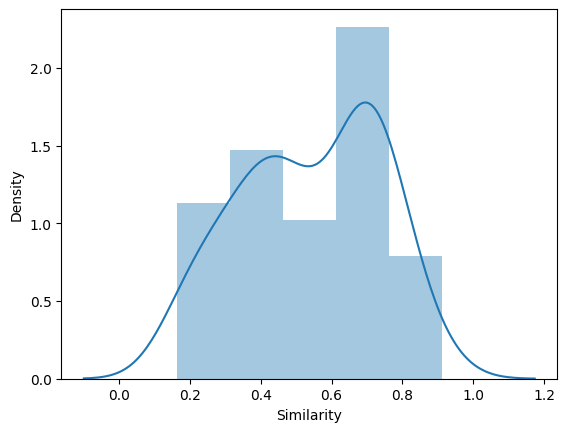

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use displot for the similarity values
sns.distplot(similarity, kde=True) 

plt.xlabel('Similarity') 
plt.ylabel('Density')
